In [1]:
import sys
sys.path.append("../scripts")

import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

save_dir = "../plots/notebook_plots/ordering/"

In [2]:
input_labels = {
    "fft": [
            # NB: cache_bandwith is missing!
            'cycle_time',
            'pipelining',
            'cache_size',
            'cache_assoc',
            'cache_hit_latency',
            'cache_line_sz',
            'cache_queue_size',
            'tlb_hit_latency',
            'tlb_miss_latency',
            'tlb_page_size',
            'tlb_entries',
            'tlb_max_outstanding_walks',
            'tlb_assoc',
            'tlb_bandwidth',
            'l2cache_size',
            'enable_l2',
            'pipelined_dma',
            'ignore_cache_flush',
        ],
    "stencil3d": [
            'cycle_time',
            'cache_size',
            'cache_assoc',
            'cache_hit_latency',
            'tlb_hit_latency',
            'tlb_entries',
            'l2cache_size',
        ],
    "gemm": [
        'cycle_time',
        'cache_size',
        'cache_assoc',
        'cache_hit_latency',
        'tlb_hit_latency',
        'tlb_entries',
        'l2cache_size',
    ],
    "smaug": [
        "num_threads",
        "l2_assoc",
        "accel_clock_time",
        "dma",
        "acp",
        "num_accels",
        "l2_size",
    ]
}

output_labels = {
    "fft": [
            'cycle',
            'avg_power',
            'idle_fu_cycles',
            'avg_fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            'num_double_precision_fp_multipliers',
            'num_double_precision_fp_adders',
            # 'num_trigonometric_units',
            # 'num_bit-wise_operators_32',
            # 'num_shifters_32',
            'num_registers_32',
        ],
    "stencil3d": [
            'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            # 'num_sp_multiplier',
            # 'num_sp_adder',
            # 'num_dp_multiplier',
            # 'num_dp_adder',
            # 'num_trig_unit',
            # 'num_multiplier',
            # 'num_adder',
            # 'num_bit_wise',
            # 'num_shifter',
            'num_register',
        ],
    "gemm": [
        'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            # 'num_sp_multiplier',
            # 'num_sp_adder',
            # 'num_dp_multiplier',
            # 'num_dp_adder',
            # 'num_trig_unit',
            # 'num_multiplier',
            # 'num_adder',
            # 'num_bit_wise',
            # 'num_shifter',
            'num_register',
    ],
    "smaug": [
        "total_time",
        "total_accel_time",
        "total_energy",
        "fu_energy",
        "spad_energy",
        "llc_leakage_energy",
        "llc_dynamic_energy",
        "total_area",
        "fu_area",
        "mem_area",
        # "num_sp_multiplier",
        # "num_sp_adder",
        # "num_dp_multiplier",
        # "num_dp_adder",
        # "num_trig_unit",
        "num_multiplier",
        "num_adder",
        "num_bit_wise",
        "num_shifter",
        "num_register"
    ]
}

separators = {
    "fft": " ",
    "stencil3d": "\t",
    "gemm": "\t",
    "smaug": ",",
}

objective_labels = {
    "fft": ['cycle', 'avg_power', 'total_area'],
    "stencil3d": ['cycle', 'avg_power', 'total_area'],
    "gemm": ['cycle', 'avg_power', 'total_area'],
    "smaug": ["total_energy", "total_time", "total_area"],
}

In [3]:
def load_permutation_effect_data(path, name):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            
            df = pd.DataFrame({
                'model': name,
                'index': row['index'],
                'output': row['outputs'],
                'perm': str(row["permutation"]),
                "rmse": row["rmse"],
                "mean_abs_err": row["mean_abs_err"],
                "mean_squ_err": row["mean_squ_err"],
                "std_mean_abs_err": row["std_mean_abs_err"],
                "std_mean_squ_err": row["std_mean_squ_err"],
                "mean_predictive_variance": row["mean_predictive_variance"],
                "mean_predictive_std": row["mean_predictive_std"]
            })
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

# Effect of using different permutations

In [17]:
!ls ../logs/fft/ordering/effect/

20200418-120252  20200418-120353  20200418-121710


In [18]:
fft_perm_effect_dict = {
    'gpar': "../logs/fft/ordering/effect/20200418-121710/permutations_25_rounds_25_data_50.json"
}

smaug_perm_effect_dict = {
    'gpar': "../logs/smaug/ordering/effect/20200415-153423/permutations_25_rounds_25_data_50.json"
}

In [19]:
data = load_permutation_effect_data(fft_perm_effect_dict["gpar"], "gpar")

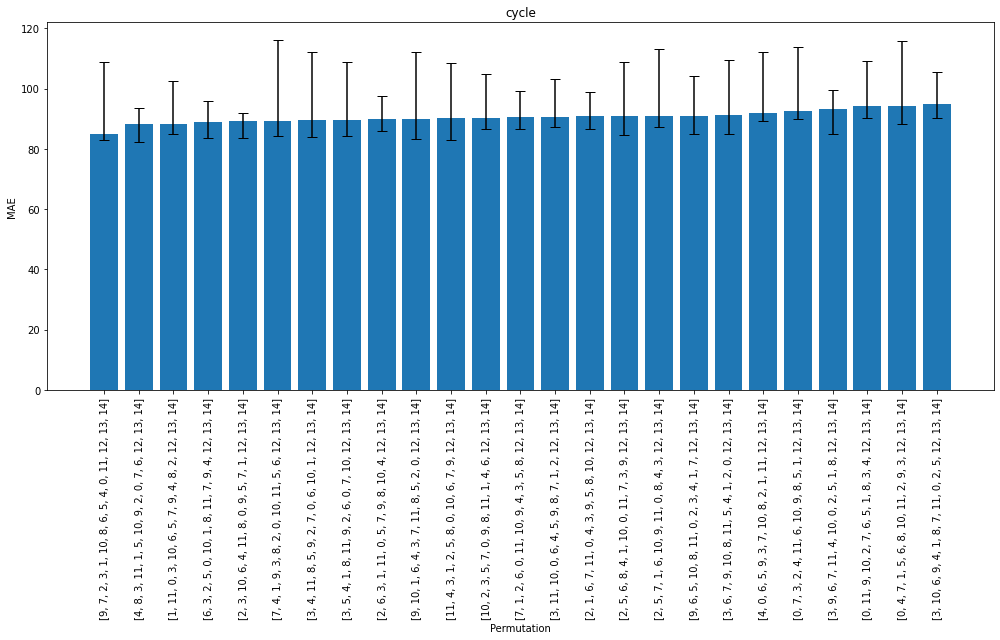

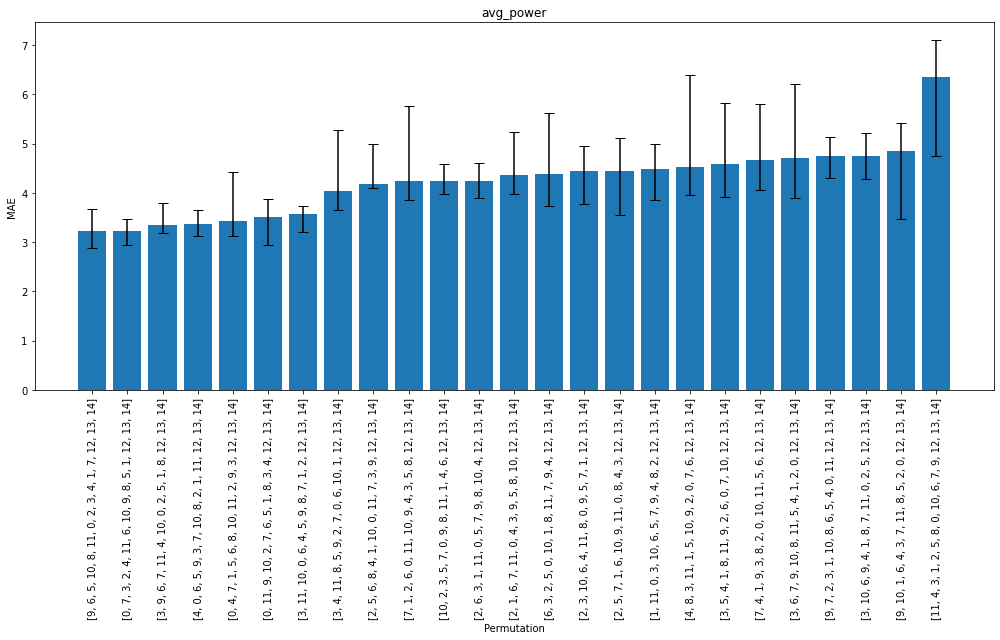

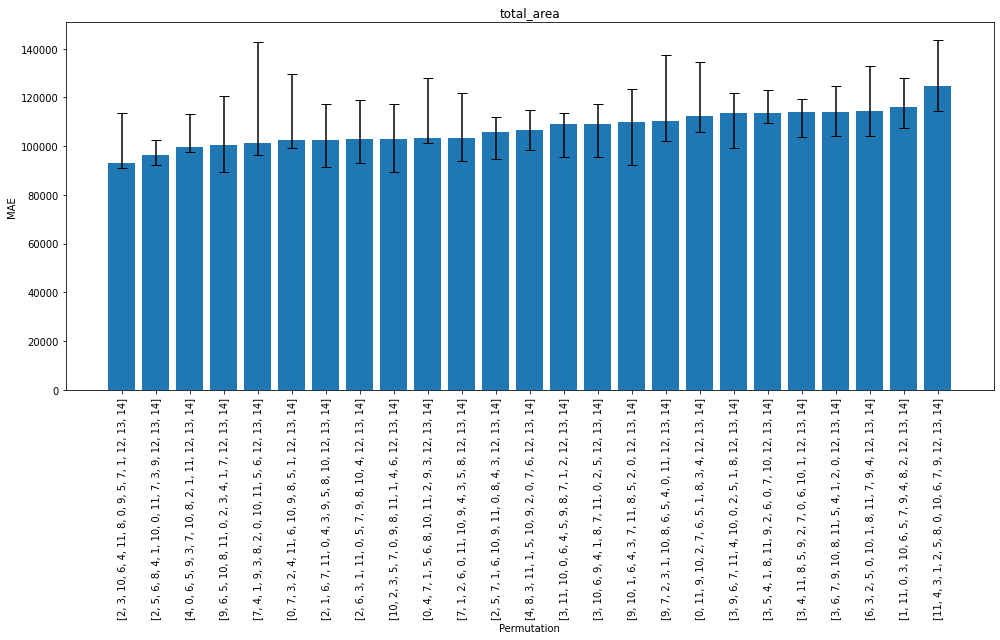

In [21]:
kind = "fft"

def first_quartile(x):
    return np.percentile(x, 25)

def third_quartile(x):
    return np.percentile(x, 75)

stats = data.groupby(['model', 'perm', 'output'])
stats = stats.aggregate({"rmse": [np.mean, np.std, np.median, first_quartile, third_quartile],
                         "mean_abs_err": [np.mean, np.std, np.median, first_quartile, third_quartile],
                         "std_mean_abs_err": [np.mean, np.std, np.median, first_quartile, third_quartile],
                         "std_mean_squ_err": [np.mean, np.std, np.median, first_quartile, third_quartile],
                         "mean_predictive_variance": [np.mean, np.std, np.median, first_quartile, third_quartile],
                         "mean_predictive_std": [np.mean, np.std, np.median, first_quartile, third_quartile],
                        }).reset_index()


for objective in objective_labels[kind]:

    target_stats = stats[stats['output'] == objective]

    medians = target_stats[('mean_abs_err', 'median')].values
    quartiles = target_stats['mean_abs_err'][['first_quartile', 'third_quartile']].values

    order = np.argsort(medians)

    medians = medians[order]
    quartiles = quartiles[order, :]
    quartiles[:, 0] = medians - quartiles[:, 0]
    quartiles[:, 1] = quartiles[:, 1] - medians

    fig, ax = plt.subplots(figsize=(14, 9))
    ax.set_title(objective)
    ax.bar(range(25), 
           medians,
           yerr=quartiles.T,
           capsize=5)
    ax.set_xticks(range(25))
    ax.set_xticklabels(target_stats['perm'].map(str).values[order], rotation=90)
    ax.set_xlabel('Permutation')
    ax.set_ylabel('MAE')
    fig.tight_layout()
    fig.savefig(f'{save_dir}/{kind}/order_effect_for_{objective}.png')
    plt.show()

In [2]:
def load_permutation_data(path, name, kind, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            
            if kind in ["greedy"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "greedy"
                })
            elif kind in ["random"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    #"sample_stats": row["sample_stats"],
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "random"
                })
            
            elif kind in ["hbo"]:
                df = pd.DataFrame({
                    'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
                    'perm': str(row["perm"]),
                    #"sample_stats": row["sample_stats"],
                    "train_time": row["train_time"],
                    "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                    
                    "search_mode": "hbo"
                })
            else:
                raise NotImplementedError()
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [4]:
def plot_stats(aggregate, stat: str, model: str, std=True):
    line_style_dict = {
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot"
    }
    
    line_color_dict = {
        "gpar": "black",
        "gp_aux": "black",
        "mf_gpar_2": "red",
        "mf_gpar_5": "green",
        "mf_gpar_8": "blue",
    }
    
    model_label = {
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }
    
    outputs = ["avg_power", "cycle", "total_area"]
    
    fig, axes = plt.subplots(nrows=len(outputs), ncols=1, figsize=(16, 8 * len(outputs)))
    
    # Plot the outputs of interest
    for output, group in aggregate.groupby('output'):
        
        if output not in outputs: 
            continue
            
        ax = axes[outputs.index(output)]
        
        d = group.sort_values((stat, "median"))
        
        perm_range = range(stats["perm"].nunique())
        
        # Interpolated plot of performance
        ax.bar(perm_range,
               d[(stat, 'median')],
               label="Median")
        ax.set_xticks(perm_range)
        ax.set_xticklabels(list(d["perm"].unique()), rotation=90)
        # Plot error bars
        ax.errorbar(x=perm_range,
                    y=d[stat]['median'],
                    yerr=d[stat][["first_perc", "third_perc"]].T.to_numpy(),
                    ecolor=line_color_dict[model],
                   fmt='None',
                   capsize=3,
                   label="1st & 3rd quartiles")
        
        ax.bar(perm_range,
               d[(stat, 'mean')],
               alpha=0.5,
               label="Mean")
        
        if std:
            ax.errorbar(x=perm_range,
                        y=d[stat]['mean'],
                        yerr=d[stat]["std"],
                        ecolor='r',
                       fmt='None',
                       capsize=3,
                       label="1 $\sigma$")

            
        ax.set_ylabel('MAE '+ label_names_dict[output], fontsize=12)
        ax.set_xlabel('Permutations', fontsize=12)
            
        ax.set_xlim([-1, stats["perm"].nunique()])
        
        ax.legend()
        
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0.6)
    return fig

In [5]:
size = 100
search_mode = "random_search"

data_path = {
    "fft": "../logs/fft/ordering",
    "stencil3d": "../logs/stencil3d/ordering",
    "gemm": "../logs/gemm/ordering",
}

gpar_file = f"gpar_size_{size}_{search_mode}_experiments.json"
mf_gpar_2_file = f"mf-gpar-2_size_{size}_{search_mode}_experiments.json"
mf_gpar_5_file = f"mf-gpar-5_size_{size}_{search_mode}_experiments.json"
mf_gpar_8_file = f"mf-gpar-8_size_{size}_{search_mode}_experiments.json"

In [6]:
experiment_files = {
#     "fft": [("gpar", gpar_file),
#             #("mf_gpar", mf_gpar_2_file), 
# #             ("mf_gpar", mf_gpar_5_file), 
# #             ("mf_gpar", mf_gpar_8_file)
#     ],
    "stencil3d": [("gpar", gpar_file),
#                   ("mf_gpar", mf_gpar_5_file), 
    ],
#     "gemm": [("gpar", gpar_file),
#              #("mf_gpar", mf_gpar_5_file), 
#     ]
}